In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import sys
sys.path.append("/export/raid1/home/styvesg/code/")

import nsd_gnet8x.src.numpy_utility as pnu
from nsd_gnet8x.src.file_utility import save_stuff, flatten_dict, embed_dict, zip_dict
from nsd_gnet8x.src.config import *

from src.utility import *
from src.sampler import *

%matplotlib inline

In [2]:
import torch
print ('#device:', torch.cuda.device_count())
print ('device#:', torch.cuda.current_device())
print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

torch.manual_seed(time.time())
device = torch.device("cuda:1") #cuda
torch.backends.cudnn.enabled=True

print ('\ntorch:', torch.__version__)
print ('cuda: ', torch.version.cuda)
print ('cudnn:', torch.backends.cudnn.version())
print ('dtype:', torch.get_default_dtype())
#torch.set_default_dtype(torch.float64)

#device: 4
device#: 0
device name: NVIDIA A100-PCIE-40GB

torch: 1.10.2+cu113
cuda:  11.3
cudnn: 8200
dtype: torch.float32


In [3]:
output_dir = root_dir + 'output/'

stim_dir = root_dir+'../../data/nsd/stims/'
voxel_dir = root_dir+'../../data/nsd/voxels/'

exp_design_file = root_dir+"../../data/nsd/nsd_expdesign.mat"

# ImageNet loader

In [5]:
imagenet_root = root_dir + "../../data/imagenet/"

In [6]:
from torchvision import datasets, transforms

data_transform = transforms.Compose([
            transforms.Resize(227), # smaller dimension will be resized to that size
            transforms.CenterCrop((227, 227)), # crop the edges of non-square images
            transforms.ToTensor(), # this automatically convert from uint8 to float in range [0,1]
            #transforms.ConvertImageDtype(torch.float32)
            #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

inet_trn = datasets.ImageNet(imagenet_root, 'train', transform=data_transform)
inet_val = datasets.ImageNet(imagenet_root, 'val', transform=data_transform)

In [7]:
label_map = inet_trn.classes
wnids_map = inet_trn.wnids

In [8]:
import torch
trn_dataloader = torch.utils.data.DataLoader(inet_trn, batch_size=10000, shuffle=True, num_workers=4)
val_dataloader = torch.utils.data.DataLoader(inet_val, batch_size=10000, shuffle=True, num_workers=4)

In [9]:
imagenet_trn_10k_images, imagenet_trn_10k_labels = next(iter(trn_dataloader))
print (imagenet_trn_10k_images.shape, imagenet_trn_10k_labels.shape)

torch.Size([10000, 3, 227, 227]) torch.Size([10000])


In [10]:
cat_sel = np.array([102, 405, 666])
title_str, file_str = '', ''
for s in cat_sel:
    title_str += ', %d: %s'%(s, label_map[s][0])
    file_str += '_%s' % label_map[s][0]
    print (s, label_map[s])

102 ('echidna', 'spiny anteater', 'anteater')
405 ('airship', 'dirigible')
666 ('mortar',)


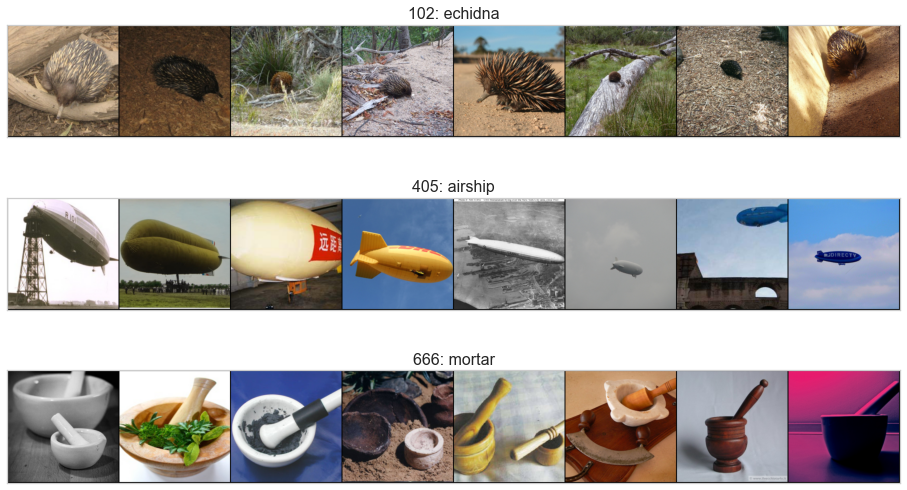

In [11]:
import torchvision
fig=plt.figure(figsize=(16,3*len(cat_sel)))
for j, c in enumerate(cat_sel):
    plt.subplot(len(cat_sel), 1, j+1)
    out = torchvision.utils.make_grid(imagenet_trn_10k_images[imagenet_trn_10k_labels==c][:8])
    plt.imshow(out.numpy().transpose((1,2,0)), cmap='gray')
    plt.title('%d: %s'%(c, label_map[c][0]), fontsize=16)
    plt.grid(False)
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])

---
# Calculate hierarchical distance form wordnet IDs.

In [29]:
from nltk.corpus import wordnet as wn

wnsynset = []
for l in wnids_map:
    wnsynset += [  wn.synset_from_pos_and_offset(l[0], int(l[1:])), ]
    
ND_mat = np.zeros(shape=(len(label_map), len(label_map)))
for i,wi in enumerate(wnsynset):
    for j,wj in enumerate(wnsynset):
        ND_mat[i,j] = wi.path_similarity(wj)
D_mat = ND_mat**(-1) - 1

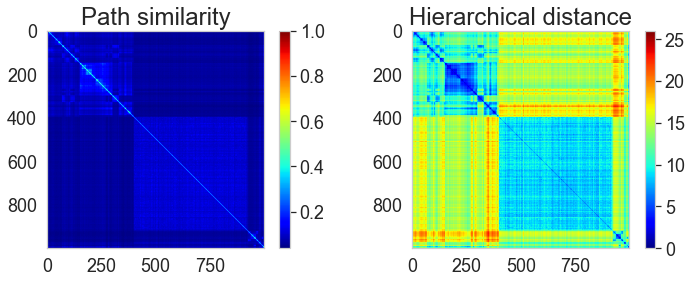

In [30]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title('Path similarity')
plt.imshow(ND_mat, cmap='jet')
plt.colorbar()
plt.grid(False)
plt.subplot(1,2,2)
plt.title('Hierarchical distance')
plt.imshow(D_mat, cmap='jet')
plt.colorbar()
plt.grid(False)

# Select subsampling regime

In [16]:
class Subsampler(object):
    def __init__(self, target_features=5000, random_projections=None):
        super(Subsampler).__init__()
        
        self.tf = target_features
        self.rp = random_projections
        self.sample_index = None
        self.proj_mat = None
        
    def apply(self, fmaps):
        if self.sample_index is None:
            self.sample_index = []
            self.proj_mat = []
            for fm in fmaps:
                ffm = fm.reshape((len(fm), -1))
                ps = ffm.shape[1]
                idx = np.arange(ps)
                np.random.shuffle(idx) 
                tf = min(self.tf, ps)
                self.sample_index += [idx[:tf],]
                if self.rp is not None:
                    self.proj_mat += [np.random.randn(tf, self.rp) / np.sqrt(self.rp),]
        ###
        sfm = []
        if self.rp is not None:
            for fm,sm,P in zip(fmaps, self.sample_index, self.proj_mat):
                sfm += [fm.reshape((len(fm), -1))[:,sm]@P,]
        else:
            for fm,sm in zip(fmaps, self.sample_index):
                sfm += [fm.reshape((len(fm), -1))[:,sm],]
        return sfm
    
    

class Subsampler(object):
    def __init__(self, random_selections=None, random_projections=None):
        super(Subsampler).__init__()
        
        self.rs = random_selections
        self.rp = random_projections
        self.sample_index = None
        self.proj_mat = None
        
    def apply(self, fmaps):
        
        sfm = []        
        if self.rs is not None: # apply the random selection
            if self.sample_index is None: # create the random sampler list
                self.sample_index = []
                for fm in fmaps:
                    ffm = fm.reshape((len(fm), -1))
                    ps = ffm.shape[1]
                    idx = np.arange(ps)
                    np.random.shuffle(idx)
                    tf = min(self.rs, ps)
                    self.sample_index += [idx[:tf],]
        
            for fm,sm in zip(fmaps, self.sample_index):
                sfm += [fm.reshape((len(fm), -1))[:,sm],]
        else:
            for fm,sm in zip(fmaps):
                sfm += [fm.reshape((len(fm), -1)),]
            
        if self.rp is not None: # apply only the random projection  
            
            if self.proj_mat is None # create the random projections matrices list
                self.proj_mat = []
                for fm in sfm:
                    ps = fm.shape[1]
                    self.proj_mat += [np.random.randn(ps, self.rp) / np.sqrt(self.rp),]    
           
            for i in range(len(sfm)): # inplace projection
                sfm[i] = sfm[i]@self.proj_mat[i]
 
        return sfm
            

def extract_image_features(image_loader, sampler):
    sfeats, pred_id = [], []
    for images, labels in image_loader:
        pred_id += [labels.numpy(),] 
        sfeats += [sampler.apply([images]),]   
    pred_id = np.concatenate(pred_id, axis=0)
    sfeats  = [np.concatenate(a) for a in zip(*sfeats)]
    return pred_id, sfeats

In [17]:
subsampler = Subsampler(target_features=50000, random_projections=500)

In [18]:
#sfm = subsampler.apply([imagenet_trn_10k_images])
#print ([fm.shape for fm in sfm])

In [20]:
labels, sfeats = extract_image_features(val_dataloader, subsampler)

In [21]:
from nsd_gnet8x.src.file_utility import save_stuff, flatten_dict, embed_dict

save_stuff( output_dir + 'imagenet_val_imagespace_features', 
    flatten_dict({
            'samples': subsampler.sample_index,
            'rproj': subsampler.proj_mat,
            'fmaps': sfeats,
            'label': labels,
            }))

saved samples@0 in h5py file
saved rproj@0 in h5py file
saved fmaps@0 in h5py file
saved label in h5py file


In [22]:
labels, sfeats = extract_image_features(trn_dataloader, subsampler)

In [23]:
from nsd_gnet8x.src.file_utility import save_stuff, flatten_dict, embed_dict

save_stuff( output_dir + 'imagenet_trn_imagespace_features', 
    flatten_dict({
            'samples': subsampler.sample_index,
            'rproj': subsampler.proj_mat,
            'fmaps': sfeats,
            'label': labels,
            }))

saved samples@0 in h5py file
saved rproj@0 in h5py file
saved fmaps@0 in h5py file
saved label in h5py file


In [9]:
data_set = h5py.File(output_dir + 'imagenet_trn_imagespace_features.h5py', 'r')
imnet_pred_dict = embed_dict({s: np.copy(d) for s,d in data_set.items()})
data_set.close()
print (imnet_pred_dict.keys())

labels = imnet_pred_dict['label']
sfeats = imnet_pred_dict['fmaps']

dict_keys(['fmaps', 'label', 'rproj', 'samples'])


In [24]:
print (labels.shape)
print (sfeats[0].shape)

(1280449,)
(1280449, 500)


## Separation of concept manifolds

In [ ]:
## manifolds[ #sample/#subject ][ #layer/#ROI ] --> 

In [25]:
from src.geometry import calculate_manifolds_directions, calculate_manifolds_SNR

manifold_dirs = calculate_manifolds_directions({'1': {'img_emb': sfeats[0]}}, labels, P=700)
save_stuff( output_dir + 'imagenet_imagespace_manifold_sample_1', flatten_dict(manifold_data))

manifold_dict = calculate_manifolds_SNR(manifold_dirs, m=5)
save_stuff( output_dir + 'imagenet_imagespace_manifold_sample_1_SNR', flatten_dict(manifold_dict))

100%|██████████| 1000/1000 [03:43<00:00,  4.48it/s]


saved R0.0 in h5py file
saved Rs.0 in h5py file
saved Us.0 in h5py file
saved P in h5py file
saved K in h5py file
saved V in h5py file
First pass


100%|██████████| 1000/1000 [01:33<00:00, 10.64it/s]


Second pass


100%|██████████| 1000/1000 [1:00:23<00:00,  3.62s/it]


saved Sign.0 in h5py file
saved Bias.0 in h5py file
saved Nsa.0 in h5py file
saved Nsb.0 in h5py file
saved Nss.0 in h5py file
saved Ds.0 in h5py file
saved SNR.0 in h5py file
saved m in h5py file
saved P in h5py file


---
# RESULT VISUALIZATION

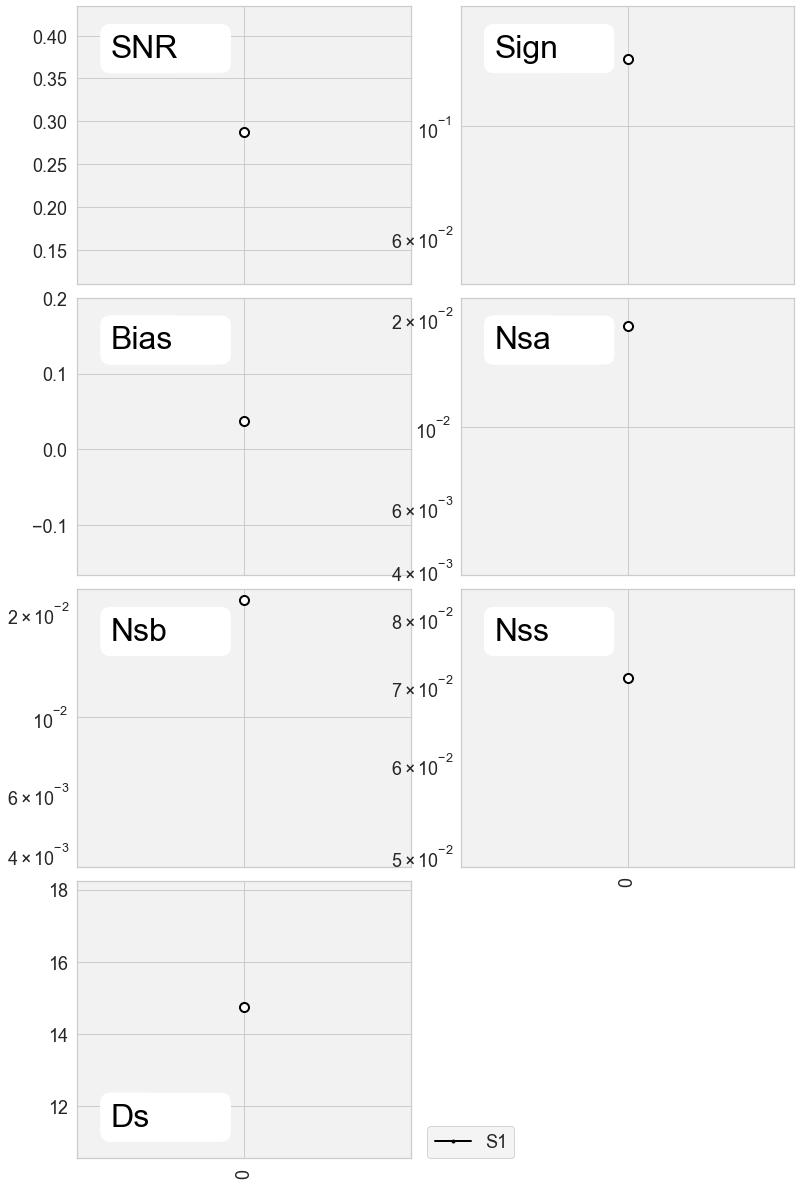

In [29]:
manifolds_pred_dict = {1: manifold_dict}
plot_roi = manifolds_pred_dict[1]['Sign'].keys()

fig = plt.figure(figsize=(12, 20))
plt.subplots_adjust(left=0.15, bottom=0.15, right=.98, top=.95, wspace=0.15, hspace=0.05)
for k,name in enumerate(['SNR', 'Sign', 'Bias', 'Nsa', 'Nsb', 'Nss', 'Ds']):
    plt.subplot(4,2,k+1)
    Ymin, Ymax = np.inf, -np.inf
    subj_all, subj_means, subj_stds = [], [], []
    for roi in plot_roi:
        Y = []
        for s in manifolds_pred_dict.keys():
            y = nanfunc(manifolds_pred_dict[s][name][roi])
            Ymin, Ymax = min(np.percentile(y, 25), Ymin), max( np.percentile(y, 75), Ymax)
            Y += [np.mean(y),]
        Y = np.array(Y)
        subj_all   += [Y,]
        subj_means += [np.mean(Y, axis=0),]
        subj_stds  += [np.std(Y, axis=0),]
    subj_all  = np.array(subj_all)
    subj_means = np.array(subj_means)
    subj_stds  = np.array(subj_stds)
    
    for i,s in enumerate(manifolds_pred_dict.keys()):
        plt.plot(np.arange(len(plot_roi)), subj_all[:,i], marker='.', lw=2, color='k', label='S%01d'%s)   #subj_cmap[s]
    plt.plot(np.arange(len(plot_roi)), subj_means, marker='o', ms=10, lw=5, color='k')   
    plt.plot(np.arange(len(plot_roi)), subj_means, marker='o', ms=6, lw=2, color='w')   
    if k>=5:
        plt.gca().set_xticks(np.arange(len(plot_roi)))
        plt.gca().set_xticklabels(plot_roi, rotation=90)
    else:
        plt.gca().set_xticks(np.arange(len(plot_roi)))
        plt.gca().set_xticklabels([])
    plt.ylim([Ymin, Ymax])
    if k==1 or k==3 or k==4 or k==5:
        plt.yscale('log')
    if k==6:
        props = dict(boxstyle='round', facecolor='white', alpha=1)
        plt.gca().text(0.1, 0.2, 'fillertext', transform=plt.gca().transAxes, fontsize=32, color='w',
            verticalalignment='top', bbox=props)
        plt.gca().text(0.1, 0.2, name, transform=plt.gca().transAxes, fontsize=32, color='k',
            verticalalignment='top', bbox=props)       
    else:
        props = dict(boxstyle='round', facecolor='white', alpha=1)
        plt.gca().text(0.1, 0.9, 'fillertext', transform=plt.gca().transAxes, fontsize=32, color='w',
            verticalalignment='top', bbox=props)
        plt.gca().text(0.1, 0.9, name, transform=plt.gca().transAxes, fontsize=32, color='k',
            verticalalignment='top', bbox=props)
    #plt.ylabel(name)
    if k==6:
        leg=plt.legend(loc=(1.05, 0.0))

In [ ]:
#filename = output_dir + "%s_manifold_geometry_all_summary%s" % (model_name, saveext)
#fig.savefig(filename, **savearg)
#plt.close()

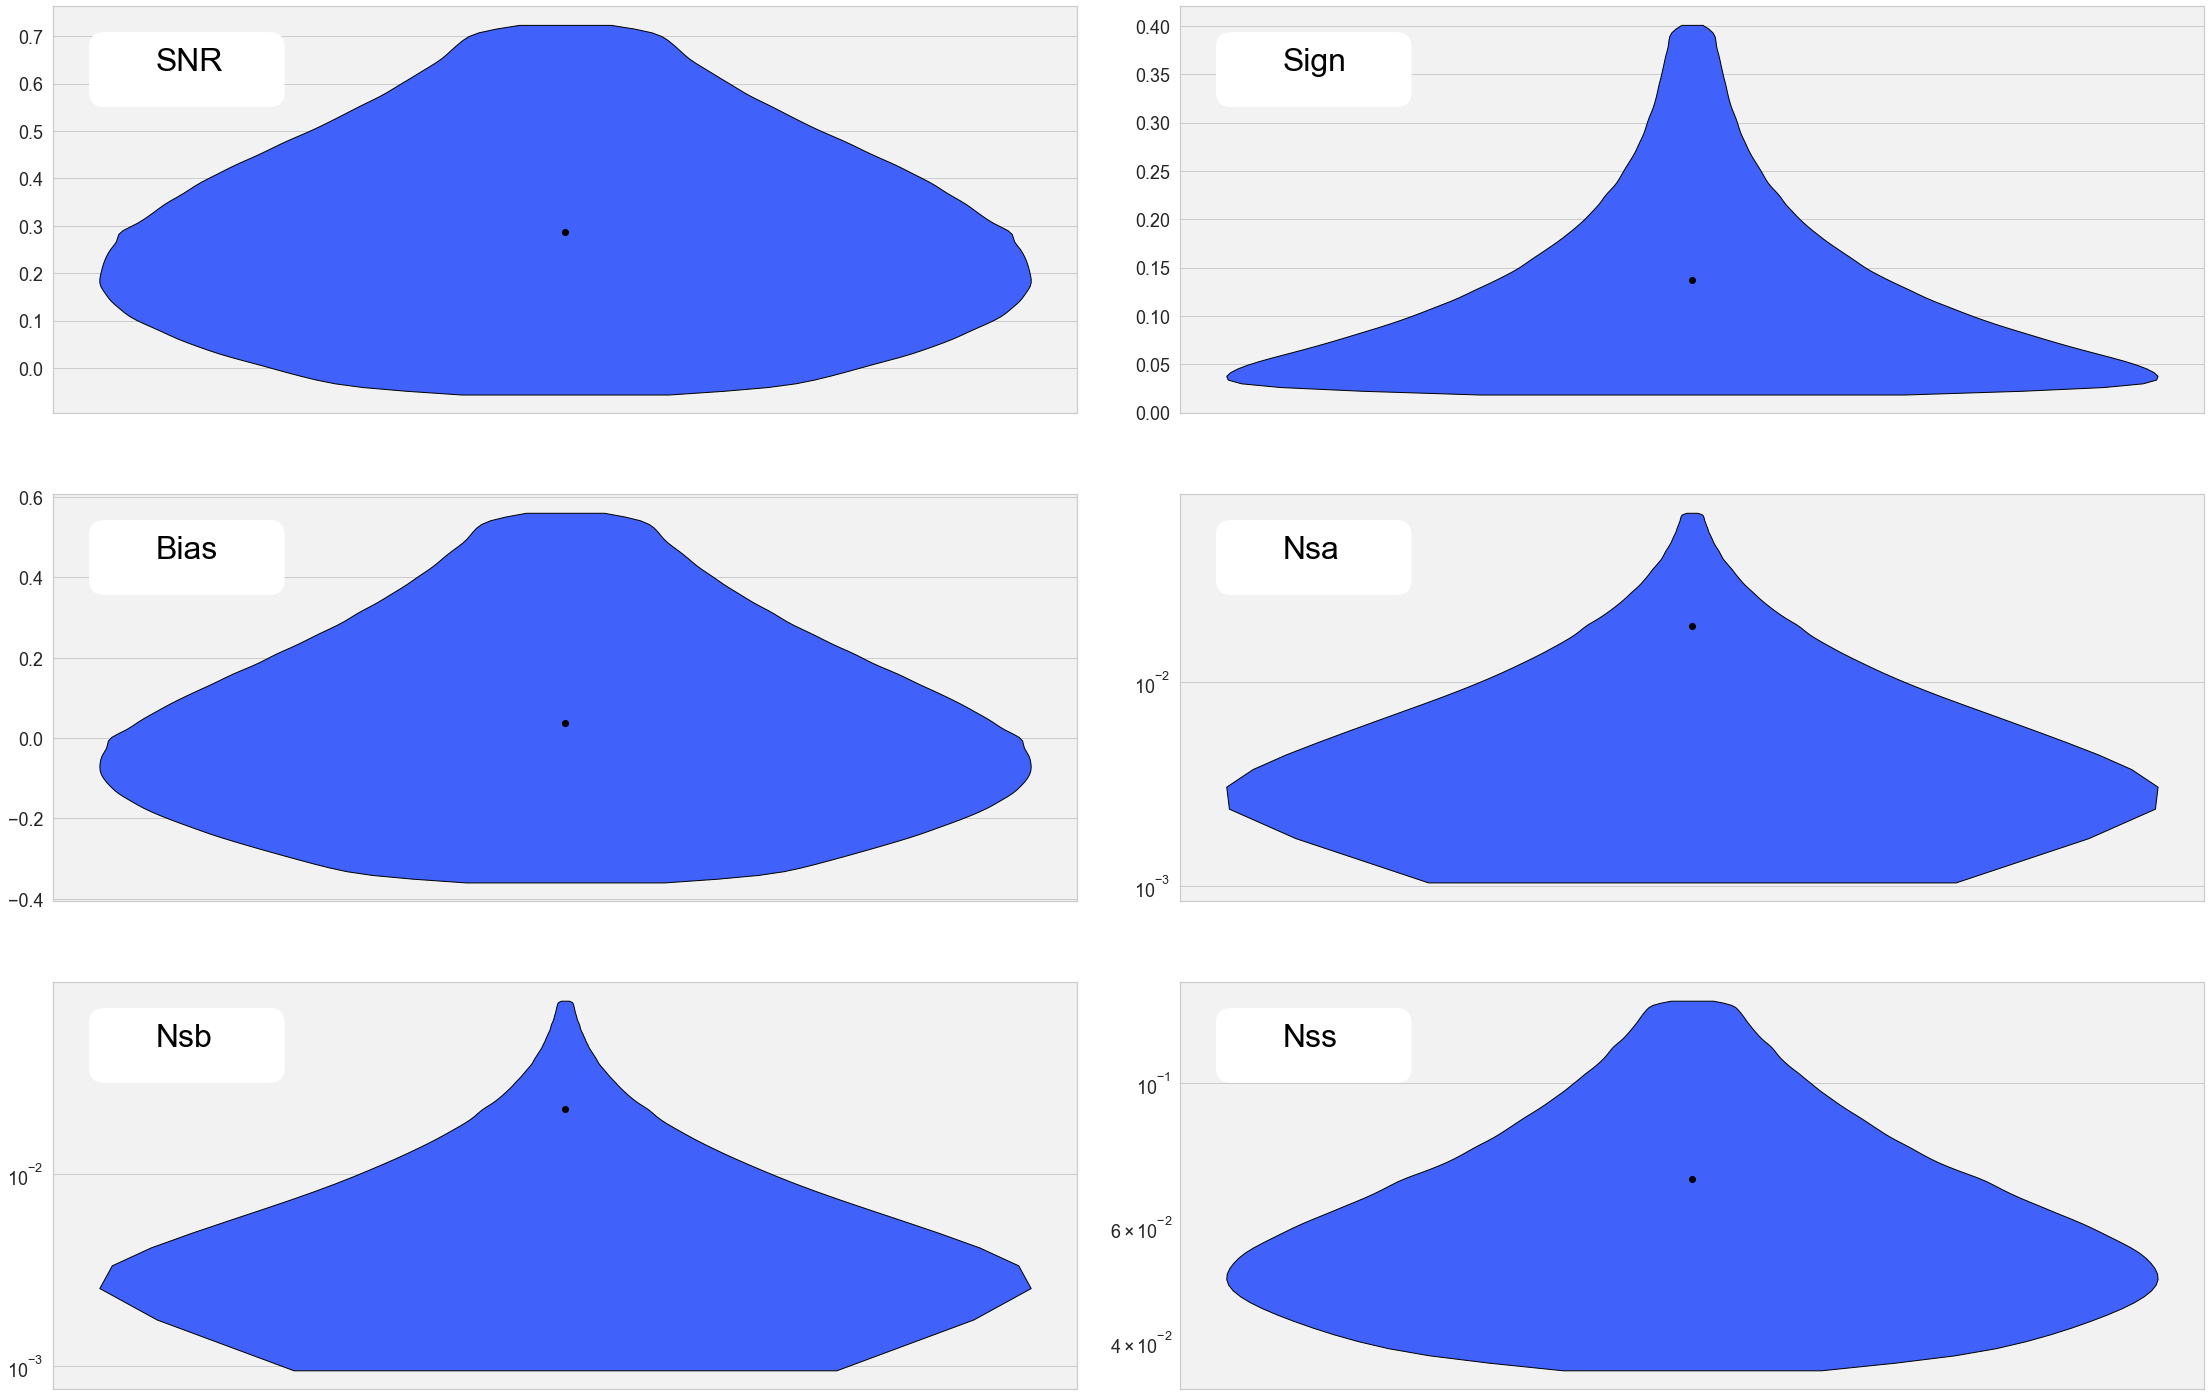

In [31]:
fig = plt.figure(figsize=(36, 24))
plt.subplots_adjust(left=0.15, bottom=0.15, right=.98, top=.95, wspace=0.1, hspace=0.2)
for k,name in enumerate(['SNR', 'Sign', 'Bias', 'Nsa', 'Nsb', 'Nss']):
    plt.subplot(3,2,k+1),
    for s in manifolds_pred_dict.keys():

        Y = [invalid_to_num((manifolds_pred_dict[s][name][r].flatten()), np.mean) for r in plot_roi]
        Ymin, Ymax = [np.percentile(y, 5) for y in Y], [np.percentile(y, 95) for y in Y]
        Yf = [y[np.logical_and(y>ymin, y<ymax)] for y,ymin,ymax in zip(Y, Ymin, Ymax)]

        parts = plt.violinplot(Yf, positions=np.arange(len(Y))+.12*s, \
            vert=True, widths=0.1, showmeans=False, showextrema=False, showmedians=False)
        for pc in parts['bodies']:
            pc.set_facecolor(subj_cmap[s])
            pc.set_edgecolor('black')
            pc.set_alpha(1)

        #for p,y in zip(np.arange(len(Y))+.12*s, Yf):
        #    _=plt.plot(np.random.normal(p, .01, size=len(y)), y, marker='.', alpha=.1, color='k', linestyle='None')
            
        _=plt.plot(np.arange(len(Y))+.12*s, [np.mean(y) for y in Y], marker='o', ms=6, color='k', linestyle='None')

    if k>=4:
        plt.gca().set_xticks(np.arange(len(plot_roi))+.5)
        plt.gca().set_xticklabels(plot_roi, rotation=90)
    else:
        plt.gca().set_xticks([])
    if k>=3:
        plt.yscale('log')
    props = dict(boxstyle='round', facecolor='white', alpha=1)
    plt.gca().text(0.05, 0.9, 'fillertext', transform=plt.gca().transAxes, fontsize=48, color='w',
        verticalalignment='top', bbox=props)
    plt.gca().text(0.1, 0.9, name, transform=plt.gca().transAxes, fontsize=32, color='k',
        verticalalignment='top', bbox=props)

In [ ]:
#filename = output_dir + "%s_manifold_geometry_all_violin%s" % (model_name, saveext)
#fig.savefig(filename, **savearg)
#plt.close()

In [4]:
def get_value(_x):
    return np.copy(_x.data.cpu().numpy())
def set_value(_x, x):
    _x.data.copy_(T.from_numpy(x))

def iterate_range(start, length, batchsize):
    batch_count = int(length // batchsize )
    residual = int(length % batchsize)
    for i in range(batch_count):
        yield range(start+i*batchsize, start+(i+1)*batchsize),batchsize
    if(residual>0):
        yield range(start+batch_count*batchsize,start+length),residual 
        
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

def get_n_random_thing_samples(things_mh, subj, a_thing, n):
    things = things_mh[subj][:,a_thing]
    thing_sample_indices = np.arange(len(things))[things.astype(bool)]    
    if n>len(thing_sample_indices):
        print ('there are less than %d things from this sort, (%d)'%(n, len(thing_sample_indices)))
        return thing_sample_indices
    np.random.shuffle(thing_sample_indices)
    return thing_sample_indices[:n]

def nanfunc(v, func=lambda x: x):
    return func((v.flatten())[np.logical_and(~np.isnan(v.flatten()), ~np.isinf(v.flatten()))])

def offdiagfunc(v, func=lambda x: x):
    return func((v.flatten())[~np.eye(len(v)).astype(bool).flatten()])

def invalid_to_num(x, value_fn=lambda x:x*0):
    sh = x.shape
    z = x.flatten()
    m = np.logical_and(~np.isnan(x.flatten()), ~np.isinf(x.flatten()))
    z[~m] = value_fn(z[m])
    return z